In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


First we read the coded aperture images and display them.

(9L, 7L)


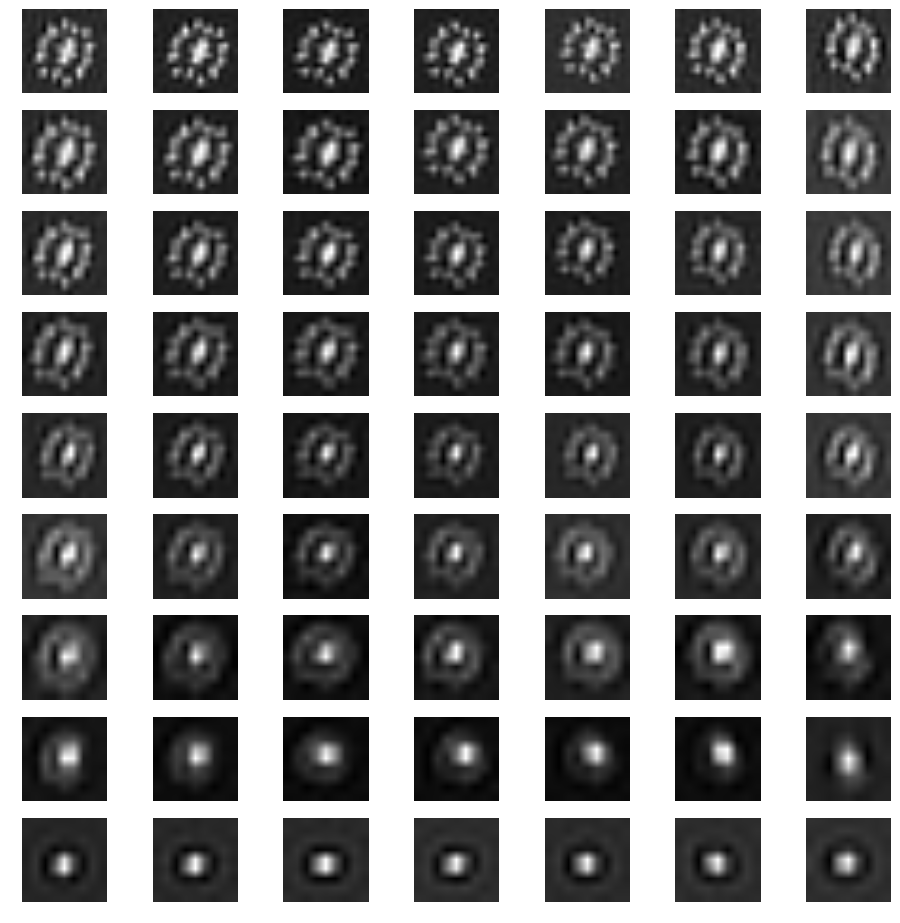

In [2]:
import scipy.io
import itertools

filters = array([scipy.io.loadmat("CodedApertureData/filts/filt_scl0" + str(i) + ".mat")["filts"] for i in range(1,10)]).squeeze()
print filters.shape

gray()
figure(figsize=(16,16))
for idx, (x, y) in enumerate(itertools.product(range(filters.shape[0]), range(filters.shape[1]))):
    subplot(filters.shape[0],filters.shape[1],idx+1)
    axis('off')
    imshow(filters[x][y])

(1171L, 1758L, 3L)


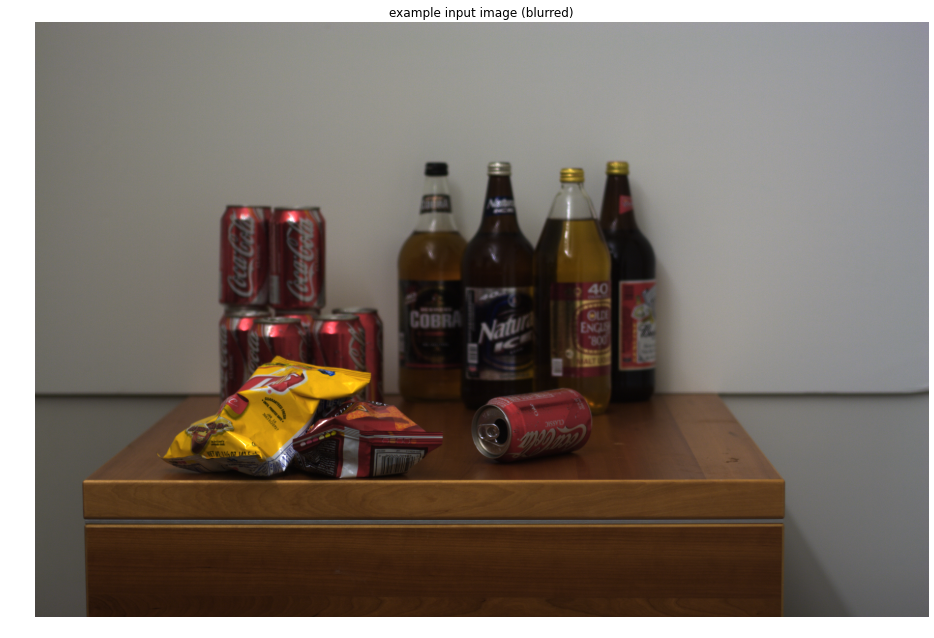

In [3]:
test_image = imread("CodedApertureData/beer_coke_inp.bmp")
figure(figsize=(16,16))
axis('off')
title("example input image (blurred)")
imshow(test_image)
print test_image.shape

Next we implement Deconvolution with Gaussian Prior in the frequency domain

In case of an RGB image we deconvolve each channel separately

In [4]:

def deconv_frequency(I, filt1, we):
    n, m = I.shape
    filt1 = fliplr(flipud(filt1))

    Gx=fft.fft2([[-1], [1]],[n,m])
    Gy=fft.fft2([[-1], [1]],[n,m])
    F = fft.fft2(filt1,[n,m])

    A = conj(F)*F + we*(conj(Gx)*conj(Gy)*Gy)
    b = conj(F)*fft.fft2(I)
    
    X = b / A
    x = fft.ifft2(X)
    
    hs1 = floor((n-1)/2)
    hs2 = floor((m-1)/2)
        
    return x

def deconv_frequency_rgb(I, filt, we):
    r = deconv_frequency(I[:,:,0], filt, we)
    g = deconv_frequency(I[:,:,1], filt, we)
    b = deconv_frequency(I[:,:,2], filt, we)
    return dstack((r.real,g.real,b.real))/256.0


We deconvolve the image with one of the filters

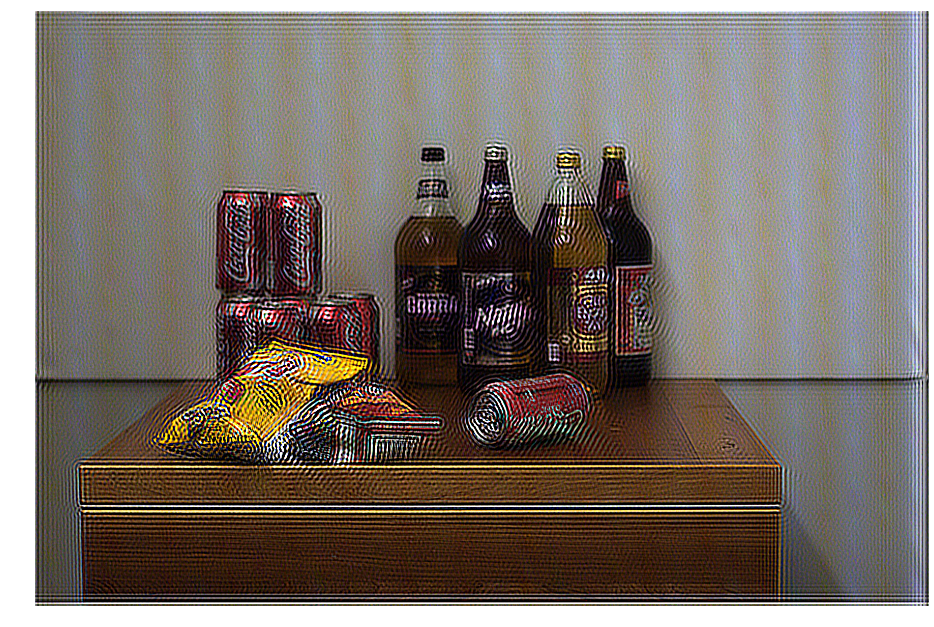

In [5]:
filter = filters[0][3]
deconvolved = deconv_frequency_rgb(test_image, filter, 0.01)

figure(figsize=(16,16))
axis('off')
imshow(clip(deconvolved,0,1))

However, we have multiple filters (7) per image, to be used at different image parts. We make it possible to use multiple filters by striping the image into 150 pixel-wide stripes.

We get around the border artifacts by adding a border to each stripe for the deconvolution, and discarding it afterwards.

In [6]:
image_parts = range(0,7)
image_parts[3] = (-75,75)
for i in range(0,3):
    image_parts[i] = (-75-150*(3-i), 75-150*(3-i))
    image_parts[4+i] = (-75+150*(i+1), 75+150*(i+1))
image_parts = array(image_parts)

def deconv_frequency_series(I, filters, we, image_parts):
    I = I.astype(float)
    _, xshape, _ = I.shape
    midx = xshape/2
    image_parts = image_parts + midx
    border = 20    
    image_parts[0][0] = border
    image_parts[-1][-1] = xshape-border
    image_parts = image_parts + [-border,border]
        
    deconvolved = zeros_like(I)
    
    for filter, image_part in zip(filters, image_parts):
        image_slice = I[:,image_part[0]:image_part[1]]
        deconvolved_slice = deconv_frequency_rgb(image_slice, filter, we)
        deconvolved[:,image_part[0]+border:image_part[1]-border] = deconvolved_slice[:,border:-border]
        
    return deconvolved

deconvolved = deconv_frequency_series(test_image, filters[0], 0.01, image_parts) 

Thus we obtain an deconvolved image composed of multiple slices

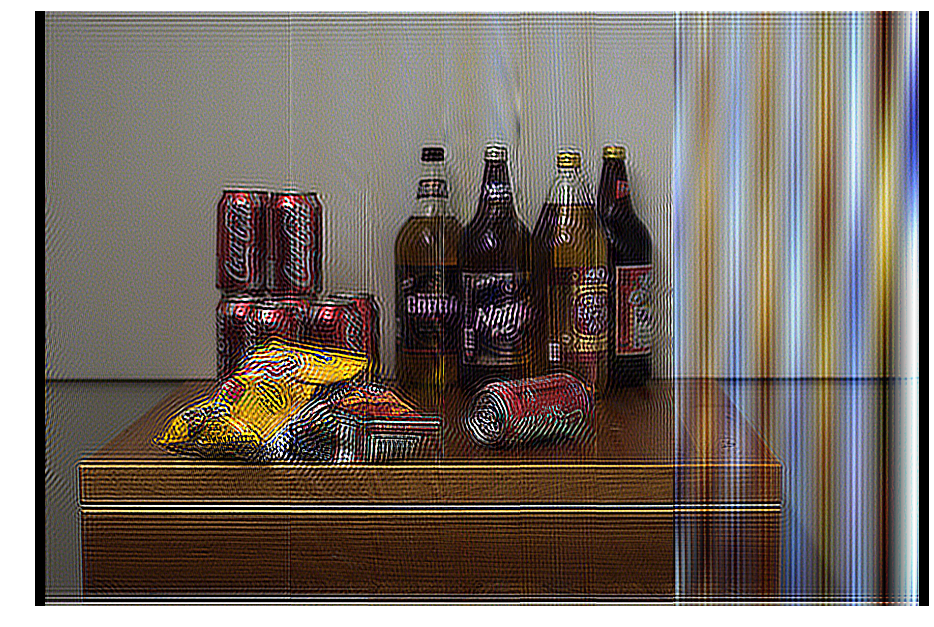

In [7]:
figure(figsize=(16,16))
axis('off')
imshow(clip(deconvolved,0,1))

Now we compute the deconvolution for each of the 9 filters from different depths.

In [9]:
#deconvolved_images = p.map(deconv_frequency_series, [(test_image, filter, 0.01, image_parts) for filter in filters])
deconvolved_images = [deconv_frequency_rgb(test_image, filter, 0.01) for filter in filters[:][3]]

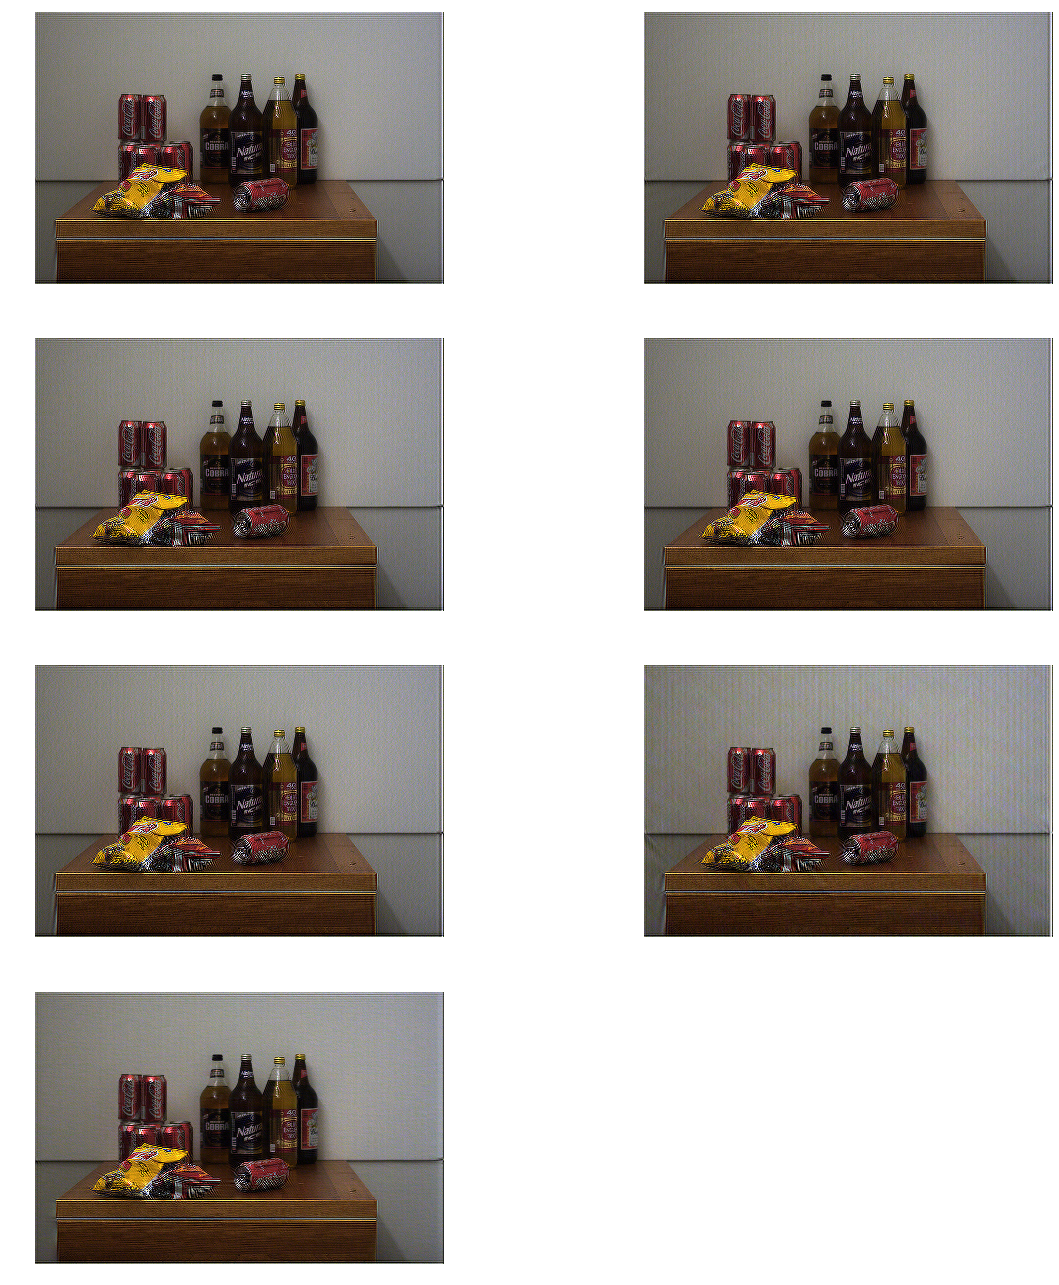

In [19]:
figure(figsize=(20,40))
for i, image in enumerate(deconvolved_images):
    subplot(7,2,i+1)
    axis('off')
    imshow(clip(image,0,1))

We compute errors for each of the deconvolved images

In [20]:
errors = [sum(test_image - dstack(convolve(filter, deconvolved[:,:,0], 'same'),
              convolve(filter, deconvolved[:,:,0], 'same'),
              convolve(filter, deconvolved[:,:,0], 'same'))
              for filter, deconvolved in zip(filters[:][3], deconvolved_images)]

gray()
figure(figsize=(20,40))
for i, image in enumerate(errors):
    subplot(7,2,i+1)
    axis('off')
    imshow(clip(image,0,1))

ValueError: object too deep for desired array

In [ ]:
window = array([[1,1,1],[1,1,1],[1,1,1]])
pixel_errors = [convolve(window,error_image, 'same') for error_image in errors]
d = argmin(pixel_errors, axis=-1)